In [24]:
import numpy as np
import pandas as pd
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from sklearn.neighbors import BallTree

### Data Cleaning

/var/folders/bl/pvtpksj10335mn0ydr2gpj4m0000gn/T/ipykernel_2333/4106431557.py:24: DtypeWarning: Columns (13,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_damage = pd.read_csv(filepath, index_col=0)


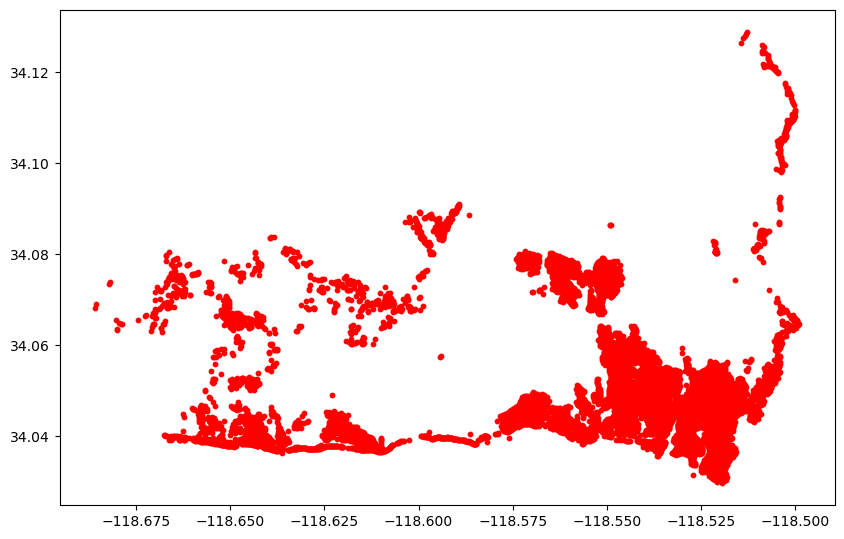

In [18]:
###     Load Population Data    ###
folder_path = "Data/Palisades-Population"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df_pop = pd.concat(df_list, ignore_index=True)
df_pop['geometry'] = df_pop.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_pop = df_pop.drop(columns=['country'])
gdf_pop = gpd.GeoDataFrame(df_pop, geometry='geometry')
gdf_pop = gdf_pop.set_crs(epsg=4326, inplace=True)

###     Load Movement Data    ###
folder_path = "Data/Palisades-Movement"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSV files
df_list = [pd.read_csv(file) for file in csv_files]
df_mov = pd.concat(df_list, ignore_index=True)
df_mov = df_mov.drop(columns=['country'])

###     Load Damage Data    ###
filepath = 'Data/Damage-Data.csv'
df_damage = pd.read_csv(filepath, index_col=0)
df_damage.columns = df_damage.columns.str.replace('*', '', regex=False).str.strip()
df_damage = df_damage[df_damage['Incident Name'] == 'Palisades']

# outline DAMAGE columns to keep
columns_to_keep = ['OBJECTID', 'Damage', 'City', 'Incident Start Date', 'Structure Type', 
                   'Year Built (parcel)', 'Latitude', 'Longitude']
df_damage = df_damage[columns_to_keep]

df_damage['geometry'] = df_damage.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_damage = gpd.GeoDataFrame(df_damage, geometry='geometry')
gdf_damage = gdf_damage.set_crs(epsg=4326, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_damage.plot(ax=ax, color='red', markersize=10, label='Damage Points')

# Reproject to EPSG:3857 (meters)
gdf_damage_proj = gdf_damage.to_crs(epsg=3857)
gdf_pop_proj = gdf_pop.to_crs(epsg=3857)

# Get total bounding box of all damage points
minx, miny, maxx, maxy = gdf_damage_proj.total_bounds

# Expand bounding box by 2km in all directions
buffer_meters = 2000
minx -= buffer_meters
miny -= buffer_meters
maxx += buffer_meters
maxy += buffer_meters

# Create expanded bounding box geometry
bounding_box = box(minx, miny, maxx, maxy)

# Filter population points within bounding box
gdf_pop_filtered = gdf_pop_proj[gdf_pop_proj.geometry.within(bounding_box)]

# Reproject back to EPSG:4326 if needed
gdf_pop = gdf_pop_filtered.to_crs(epsg=4326)
# 1m 40s <-- ~how long it takes this cell to run -b

### Damage Data Labeling
1. Extract the centroids and quadkeys from $\texttt{gdf\_pop}$.

2. Build a spatial index using those centroids.

3. For each point in $\texttt{gdf\_damage}$, find the nearest population tile centroid.

4. Add the corresponding quadkey to the damage point.

5. Return the enriched $\texttt{gdf\_damage}$ with quadkey assigned.

In [40]:
# Step 1: Extract coordinates from both datasets
pop_coords = np.radians(np.array([[geom.y, geom.x] for geom in gdf_pop.geometry]))  # lat, lon
damage_coords = np.radians(np.array([[geom.y, geom.x] for geom in gdf_damage.geometry]))

# Step 2: Build spatial index using BallTree (haversine distance)
tree = BallTree(pop_coords, metric='haversine')

# Step 3: Query nearest neighbor (returns distance and index)
distances, indices = tree.query(damage_coords, k=1)

# Step 4: Assign quadkeys based on nearest neighbor index
nearest_quadkeys = gdf_pop.iloc[indices.flatten()].quadkey.values
gdf_damage['quadkey'] = nearest_quadkeys

# Convert distance from radians to kilometers (for reference)
gdf_damage['distance_km'] = distances.flatten() * 6371  # Earth's radius in km

gdf_damage.to_csv('Data/Labeled-Damage-Data.csv', index=False)

### Check-Work Code

Empty DataFrame
Columns: [quadkey, latitude, longitude]
Index: []


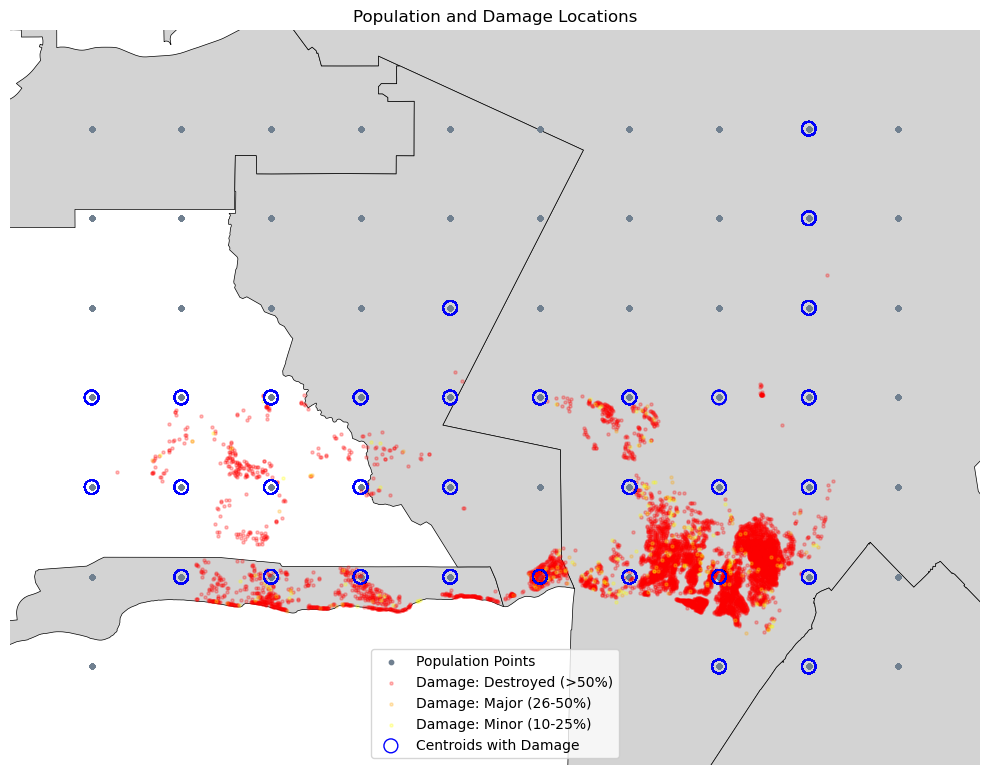

In [39]:
from sklearn.neighbors import BallTree
def tile_dist():
    # Step 1: Drop duplicates and convert to numpy
    coords = gdf_pop[['latitude', 'longitude']].drop_duplicates().to_numpy()
    coords_rad = np.radians(coords)

    # Step 2: BallTree with haversine distance
    tree = BallTree(coords_rad, metric='haversine')
    distances, _ = tree.query(coords_rad, k=2)  # self + nearest

    # Step 3: Convert to kilometers
    nearest_distances_km = distances[:, 1] * 6371

    # Step 4: Compute average
    average_distance_km = nearest_distances_km.mean()
    print(f"Average distance to nearest neighbor: {average_distance_km:.2f} km")


def plot_test():
    gdf_basemap = gpd.read_file("Data/ca_places/CA_Places.shp")
    gdf_basemap.set_crs(epsg=3857, inplace=True)
    gdf_basemap = gdf_basemap.to_crs(gdf_pop.crs)

    # Define a color map for the categories
    damage_colors = {
        'No Damage': 'lightskyblue',
        'Affected (1-9%)': 'green',
        'Minor (10-25%)': 'yellow',
        'Major (26-50%)': 'orange',
        'Destroyed (>50%)': 'red',
    }

    # Create a new column for the color values
    gdf_damage['color'] = gdf_damage['Damage'].map(damage_colors)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot basemap
    gdf_basemap.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

    # Plot population points
    gdf_pop.plot(ax=ax, color='slategrey', markersize=10, label='Population Points')

    # Plot damage points
    #gdf_damage.plot(ax=ax, color='red', markersize=5, alpha=0.25, label='Damage Points',)

    # Plot damage points by category
    for damage_level, group in gdf_damage.groupby('Damage'):
        if damage_level in ['No Damage', 'Affected (1-9%)']:
            # Skip these categories
            continue
        group.plot(ax=ax,
                color=damage_colors.get(damage_level, 'grey'),
                markersize=5,
                alpha=0.25,
                label=f'Damage: {damage_level}')

    # Highlight centroids with damage
    quadkeys_with_damage = set(gdf_damage['quadkey'].to_list())
    centroids_to_label = gdf_pop[gdf_pop['quadkey'].isin(quadkeys_with_damage)]

    # Optionally plot with a different color
    centroids_to_label.plot(ax=ax, facecolor='none', edgecolor='blue', markersize=100, label='Centroids with Damage')

    # Customize
    ax.set_title("Population and Damage Locations")
    # Get bounds of gdf_pop
    minx, miny, maxx, maxy = gdf_pop.total_bounds

    lat_buffer = 0.02     # ~2.2 km
    lon_buffer = 0.02     # ~1.7–2.2 km depending on latitude

    # Set axis limits
    ax.set_xlim(minx - lon_buffer, maxx + lon_buffer)
    ax.set_ylim(miny - lat_buffer, maxy + lat_buffer)
    ax.legend()
    ax.set_axis_off()
    plt.tight_layout()
plot_test()

def check_quadkey():
    # Group by quadkey and count unique lat/lon pairs
    inconsistent_quadkeys = (
        gdf_pop.groupby('quadkey')[['latitude', 'longitude']]
        .nunique()
        .reset_index()
    )

    # Check for quadkeys that have multiple latitudes or longitudes
    inconsistent_quadkeys = inconsistent_quadkeys[
        (inconsistent_quadkeys['latitude'] > 1) | (inconsistent_quadkeys['longitude'] > 1)
    ]

    print(inconsistent_quadkeys)
check_quadkey()